In [ ]:
'''
Licensed Materials - Property of IBM
IBM Maximo APM - Predictive Maintenance Insights On-Premises
IBM Maximo APM - Predictive Maintenance Insights SaaS 
© Copyright IBM Corp. 2019 All Rights Reserved.
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.
'''

# Maximo APM PMI - Custom Model Development

1. [Introduction](#introduction)
1. [Install Maximo APM PMI SDK](#install-maximo-apm-pmi-sdk)
1. [Customize Out-of-Box Anomaly Detection Model](#customize-anomaly-detection-model)
    1. [Package Custom Code](#package-custom-code)
1. [Setup the Model Training Pipeline](#setup-model-training-pipline)
    1. [Test Custom Code](#test-custom-code)
1. [Train the Model Instance](#train-model-instance)
1. [Register the Trained Model Instance](#register-trained-model-instance)

<a id='introduction'></a>
## Introduction

Maximo APM PMI supports custom models in addtion to the 5 out-of-box models. There are 2 approaches supported by PMI for the custom model development. The first approach is to develop/train your custom models with tools of your choice then deploy to Watson Machine Learning (WML). PMI supports using WML for scoring. With this approach, you can use any [machine learning framework supported](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html?audience=wdp) by WML with Maximo APM PMI. You can see details on using this approch in the notebook "PMI - Using Models Deployed on WML".

The other approach is more native to PMI which only supports pure Python machine learning frameworks. You develop, train, and deploy your custom models with PMI SDK. In fact, the 5 out-of-box models fall in this category. In this notebook, we'll talk about this approach.

Note that Maximo APM PMI UI does not yet support custom models. Only the out-of-box models can be visualized on the UI. The generated prediction results are stored in data lake and can be added to dashboard cards, used to calculate asset health scores, or retrieved by API.

Before you can start, similar to using the out-of-box model pipelines, you need to install PMI SDK first.

<a id="install-maximo-apm-pmi-sdk"></a>
## Install Maximo APM PMI SDK

To install the SDK, you need your Maximo APM PMI instance ID, API base URL, and your API key. The Maximo APM PMI instance ID and API base URL can be found in the user welcome letter. For API key, request to your Maximo admin to create an user account first to generate one for you. Create one environment variable for each here.

In [ ]:
# The code was removed by Watson Studio for sharing.

Then, install PMI SDK with `pip`. Note that we have to upgrade `pip` first.

In [ ]:
# The code was removed by Watson Studio for sharing.

<a id="customize-anomaly-detection-model"></a>
## Customize Out-of-Box Anomaly Detection Model

Let's use an example of customing the out-of-box anomaly detection model as an example of how to create custom models. Let's say we want to change the algorithms used by the anomaly detection model to be solely composed on covariance structure based ones. You can reference the original out-of-box anomaly detection model in notebook "PMI - Anomaly Detection".

A model template is mainly composed of two Python classes: one asset group pipeline class and the other estimator class. The pipeline class is responsible for settin up the model processing pipeline. A pipeline always starts with a data loader, which can load asset data and/or sensor data. A pipeline also contains one or more processing stages, each stage can be feature extraction, data pre-processing, or estimator (which learns from data). There can also be post-processing summarization at the end of the pipeline. In most cases, a pipeline has one estimator and a few pre-processing or post-processing stages. However, it is also possible to put more than one estimator in a pipeline, in which case, they use the same inputs.

Estimator class is for the machine learning itself. It takes the input, features, to train the models, and with the models trained, to generate prediction results.

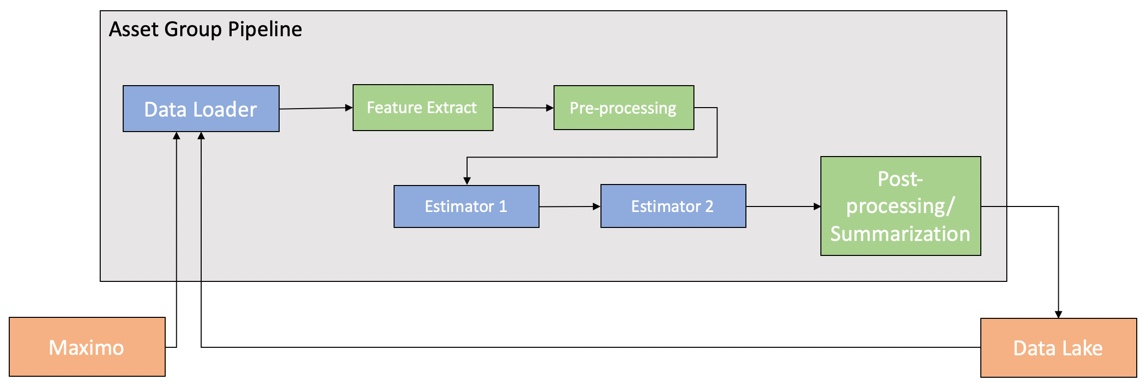

To create custom models, you implment two Python classes inheriting from PMI SDK base classes. In this example, since we are modifying the anomaly detection model, we will create a estimator class inheriting from **```pmlib.anomaly_detection.AnomalyDetectionEstimator```** and a pipeline class inheriting from **```AnomalyDetectionAssetGroupPipeline```**. Since we jsut want to change the algorithms used, all we need to do is to override estimator's method **```get_stages```**. However, we do need to also create a custom pipeline class as an entry point to the customized anomaly detection model.

In [ ]:
from pmlib.anomaly_detection import AnomalyDetectionEstimator, AnomalyDetectionAssetGroupPipeline

class CustomAnomalyDetectionEstimator(AnomalyDetectionEstimator):
    def get_stages(self):
        from sklearn.covariance import (EmpiricalCovariance, EllipticEnvelope, LedoitWolf, MinCovDet, OAS, ShrunkCovariance)
        from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
        from srom.anomaly_detection.generalized_anomaly_model import GeneralizedAnomalyModel
        from srom.utils.no_op import NoOp

        return [
            [
                ('skipscaling', NoOp()), 
                ('standardscaler', StandardScaler()),
                ('robustscaler', RobustScaler()), 
                ('minmaxscaling', MinMaxScaler())
            ],
            [
                # Covariance Structure based Anomaly Models
                ('empiricalcovariance', GeneralizedAnomalyModel(base_learner=EmpiricalCovariance(), fit_function='fit', predict_function='mahalanobis',score_sign=1)), 
                ('ellipticenvelope', GeneralizedAnomalyModel(base_learner=EllipticEnvelope(), fit_function='fit', predict_function='mahalanobis',score_sign=1)),
                ('ledoitwolf', GeneralizedAnomalyModel(base_learner=LedoitWolf(), fit_function='fit', predict_function='mahalanobis',score_sign=1)), 
                ('mincovdet', GeneralizedAnomalyModel(base_learner=MinCovDet(), fit_function='fit', predict_function='mahalanobis',score_sign=1)), 
                ('oas', GeneralizedAnomalyModel(base_learner=OAS(), fit_function='fit', predict_function='mahalanobis',score_sign=1)), 
                ('shrunkcovariance', GeneralizedAnomalyModel(base_learner=ShrunkCovariance(), fit_function='fit', predict_function='mahalanobis',score_sign=1)),
            ]
        ]

    
class CustomAnomalyDetectionAssetGroupPipeline(AnomalyDetectionAssetGroupPipeline):
    pass

<a id="package-custom-code"></a>
### Package Custom Code

Notebook is not a good way for code reuse. Maximo APM PMI is not able to get the code out of this notebook. In order to have our new custom model work in APM PMI (doing prediction results generation with live data), we need to package it as a standard Python library.

We need to create a Python project on local machine to put our new code. Here's a sample project structure:

```
+-- setup.py
+-- custom_models
  + __init__.py
  + anomaly.py
```

Below is a sample ```setup.py``` you can use, which creates a library called ```my-pmi-custom-module``` and has dependency on PMI SDK. You do need to choose a meaningful name as the library name to avoid libary name conflict and also replace all of ```<APM_API_BASEURL>```, ```<APM_ID>```, and ```<APM_API_KEY>``` with your PMI instance values.

In [ ]:
#!/usr/bin/env python

from setuptools import setup, find_packages

setup(
    name='my-pmi-custom-models',
    version='0.1',
    packages=find_packages(),
    install_requires=[
        'pmlib@<APM_API_BASEURL>/ibm/pmi/service/rest/ds/<APM_ID>/<APM_API_KEY>/lib/download?filename=pmlib-1.0.0-master.tar.gz'
    ]
)

Put the new code in file **```anomaly.py```** under the module directory **```custom_models```**. **```__init__.py```** can be just an empty content file (this is Python standard way denoting the directory **```custom_models```** is a module). You can then put this project on Github. Create a project named **```my-pmi-custom-models```** and push the project content to there.

With the project ready, we can register the new custom model to Maximo APM PMI. But let's do some testing first.

<a id="setup-model-training-pipline"></a>
## Setup the Model Training Pipeline

This is exactly same as using the out-of-box anomaly detection model (as in the notebook "PMI - Anomaly Detection"), except we have switched the pipeline class name. But we also need to install the custom code from the remote project repository we just created on Github:

In [ ]:
!pip install git+https://github.com/<username>/my-pmi-custom-models.git

from custom_models.anomaly import CustomAnomalyDetectionAssetGroupPipeline

group = CustomAnomalyDetectionAssetGroupPipeline(
            asset_group_id='<asset_group_id>', 
            model_pipeline={
                "features": ["SampleAnomalySensor:x1", "SampleAnomalySensor:x2", "SampleAnomalySensor:x3", "SampleAnomalySensor:x4", "SampleAnomalySensor:x5", "SampleAnomalySensor:x6", "SampleAnomalySensor:x7", "SampleAnomalySensor:x8", "SampleAnomalySensor:x9", "SampleAnomalySensor:x10", "SampleAnomalySensor:x11", "SampleAnomalySensor:x12", "SampleAnomalySensor:x13", "SampleAnomalySensor:x14", "SampleAnomalySensor:x15", "SampleAnomalySensor:x16", "SampleAnomalySensor:x17", "SampleAnomalySensor:x18", "SampleAnomalySensor:x19", "SampleAnomalySensor:x20", "SampleAnomalySensor:x21", "SampleAnomalySensor:x22", "SampleAnomalySensor:x23", "SampleAnomalySensor:x24", "SampleAnomalySensor:x25", "SampleAnomalySensor:x26", "SampleAnomalySensor:x27", "SampleAnomalySensor:x28", "SampleAnomalySensor:x29", "SampleAnomalySensor:x30", "SampleAnomalySensor:x31", "SampleAnomalySensor:x32", "SampleAnomalySensor:x33", "SampleAnomalySensor:x34", "SampleAnomalySensor:x35", "SampleAnomalySensor:x36", "SampleAnomalySensor:x37", "SampleAnomalySensor:x38", "SampleAnomalySensor:x39", "SampleAnomalySensor:x40", "SampleAnomalySensor:x41", "SampleAnomalySensor:x42"],
                "features_for_training": [":faildate"],
                "predictions": ["anomaly_score", "anomaly_threshold"],
                "srom_training_options": {
                    "exectype": "spark_node_random_search" # spark_node_random_search or spark_node_complete_search
                }
            })

Note the module here is our new code's ```custom_models```.

<a id="train-model-instance"></a>
## Train the Model Instance
Now you can train the model instance.

In [ ]:
df = group.execute()

Once this method completes successfully, you'll have a trained model instance reday (for next step, see below) and also with the prediction results returned as a dataframe for verification.

<a id="register-trained-model-instance"></a>
## Register the Trained Model Instance

If the trained model instance looks good, you can register it to Maximo APM PMI. Note the difference here from the out-of-box model, we have specified the URL to the Github repository storing our custom mode code:

In [ ]:
group.register(url='git+https://github.com/<username>/my-pmi-custom-models.git', df=df)

Once registration succeeds, you can see this newly trained model instance available for the asset group on IBM Maximo APM - AHI.